# BMA

This data script is designed to run in another environment. It is not intended to be run in the Streamlit app.

Furthermore, the directory structure is not the same as the Streamlit app.

In [ ]:
import os
import numpy as np
import pandas as pd
import random
from pathlib import Path

from utils.data_loader import load_data, prepare_model_data, get_available_symbols
from utils.models import train_model
from utils.metrics import calculate_metrics

# from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from tensorflow.keras.models import load_model

HARDCODED_LSTM_PATH = "trained_models/LSTM_8662e15cd642d63553f08b7b8bca0bb5.keras"
pretrained_lstm_model = load_model(HARDCODED_LSTM_PATH)

# Helper functions -----------------------------------------
def predict_with_lstm(model, df, feature_cols, target_col, lookback, symbols):
    from utils.data_loader import reshape_lstm_data
    X, y = reshape_lstm_data(df, feature_cols, target_col, lookback, symbols)
    y_pred = model.predict(X).ravel()
    return y_pred, y

def block_bootstrap_indices(n_obs, block_size=100, n_blocks=None):
    if n_blocks is None:
        n_blocks = n_obs // block_size
    start_points = np.random.randint(0, n_obs - block_size, size=n_blocks)
    blocks = [np.arange(start, start + block_size) for start in start_points]
    boot_idx = np.concatenate(blocks)
    boot_idx = boot_idx[boot_idx < n_obs]  # Ensure valid range
    oob_idx = np.setdiff1d(np.arange(n_obs), boot_idx)
    return boot_idx, oob_idx


# Reproducibility ----------------------------------------------
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Define models and hyperparameters ------------------------------
models_config = {
    "Linear Regression": {},
    "Lasso Regression": {"alpha": 0.001},
    "Ridge Regression": {"alpha": 0.01},
    "Elastic Net": {"alpha": 0.001, "l1_ratio": 0.05},
    "PCR": {},
    "PLS": {},
    "Random Forest": {"n_estimators": 200, "max_depth": 5},
    "XGBoost": {"n_estimators": 200, "learning_rate": 0.1, "max_depth": 3},
    "CatBoost": {"iterations": 200, "learning_rate": 0.1, "depth": 6},
    "Feedforward NN": {"epochs": 200},
    "LSTM": {"epochs": 200, "lookback": 5}
}

model_names = list(models_config.keys())
N_BOOTSTRAP = 50

# Main execution ----------------------------------------------
def main():
    print("🔄 Loading data...")
    df = load_data()
    test_size = 0.2

    print("📐 Preparing model data...")
    # Prepare for tabular models
    indicator_cols, _, _, _, X_train, X_test, y_train, y_test, symbols = prepare_model_data(df, "Linear Regression", test_size)

    # Prepare for LSTM
    indicator_cols_lstm, df_train, df_test, _, _, _, _, _, _ = prepare_model_data(df, "LSTM", test_size)

    symbols_all = get_available_symbols(df)

    oob_errors = {m: [] for m in model_names}
    n_train = len(y_train)
    indices = np.arange(n_train)

    print("🚀 Starting bootstrapped training...")
    for m in model_names:
        print(f"🔁 Model: {m}")
        for b in range(N_BOOTSTRAP):
            boot_idx, oob_idx = block_bootstrap_indices(n_train, block_size=100)

            if oob_idx.size == 0:
                continue

            if m == "LSTM":

                lookback = models_config[m]["lookback"]

                df_boot = df_train.iloc[boot_idx].copy()
                df_oob = df_train.iloc[oob_idx].copy()

                # Ensure time and symbol sort
                df_boot.sort_values(["symbol", "timestamp"], inplace=True)
                df_oob.sort_values(["symbol", "timestamp"], inplace=True)


                boot_symbols = df_boot["symbol"].unique()
                oob_symbols = df_oob["symbol"].unique()
                valid_symbols = list(set(boot_symbols) & set(oob_symbols))

                try:
                    df_boot_valid = df_boot[df_boot["symbol"].isin(valid_symbols)].copy()
                    df_oob_valid = df_oob[df_oob["symbol"].isin(valid_symbols)].copy()

                    if df_boot_valid.empty or df_oob_valid.empty or len(valid_symbols) == 0:
                        print(f"⚠️ Skipping LSTM iter {b} — no overlapping valid data.")
                        continue

                    print(f"🧪 Iter {b}: using symbols → {valid_symbols}")
                    print(f"📊 Indicator Cols: {indicator_cols_lstm}")

                    y_pred_oob, y_true_oob = predict_with_lstm(pretrained_lstm_model, df_oob_valid, indicator_cols_lstm, "target", lookback, valid_symbols)

                    # Filter df_oob to only include valid_symbols
                    df_oob_valid = df_oob_valid.sort_values(["symbol", "timestamp"]).reset_index(drop=True)

                except Exception as e:
                    print(f"❌ LSTM error in iter {b}: {e}")
                    continue
            else:
                try:
                    X_boot, y_boot = X_train[boot_idx], y_train[boot_idx]
                    X_oob, y_true_oob = X_train[oob_idx], y_train[oob_idx]
                    _, y_pred_oob = train_model(m, X_boot, y_boot, X_oob, models_config[m])
                except Exception as e:
                    print(f"❌ Error training {m} in iter {b}: {e}")
                    continue

            try:
                r2 = r2_score(y_true_oob, y_pred_oob)
                oob_errors[m].append(1-r2)
            except Exception as e:
                print(f"⚠️ Error computing MSE for {m}: {e}")

    print("\n✅ Computing BMA Weights...")

    avg_r2_error = {m: np.mean(oob_errors[m]) if oob_errors[m] else np.inf for m in model_names}
    lambda_param = 1.45
    raw_weights = {m: np.exp(-lambda_param * avg_r2_error[m]) for m in model_names}
    total_weight = sum(raw_weights.values())
    bma_weights = {m: (raw_weights[m] / total_weight if total_weight != 0 else 0) for m in model_names}

    print("📊 Final BMA Weights:")
    for m, w in bma_weights.items():
        print(f"{m}: {w:.4f}")

    print("\n🔄 Retraining all models on full training data...")
    individual_train_preds = {}
    individual_test_preds = {}
    metrics_train = {}
    metrics_test = {}

    for m in model_names:
        print(f"✅ {m}")
        try:
            if m == "LSTM":

                y_test_pred, y_test_real = predict_with_lstm(pretrained_lstm_model, df_test, indicator_cols_lstm, "target", lookback, symbols_all)
                y_train_pred, y_train_real = predict_with_lstm(pretrained_lstm_model, df_train, indicator_cols_lstm, "target", lookback, symbols_all)

            else:
                model, y_test_pred = train_model(m, X_train, y_train, X_test, models_config[m])
                y_train_pred = model.predict(X_train)
                y_train_real = y_train[:len(y_train_pred)]
                y_test_real = y_test[:len(y_test_pred)]

            individual_train_preds[m] = y_train_pred
            individual_test_preds[m] = y_test_pred

            metrics_train[m] = calculate_metrics(y_train_real, y_train_pred)
            metrics_test[m] = calculate_metrics(y_test_real, y_test_pred)
            individual_train_preds[f"{m}_y"] = y_train_real
            individual_test_preds[f"{m}_y"] = y_test_real

            print(f"{m} → Train: {len(y_train_pred)}, {len(y_train_real)} | Test: {len(y_test_pred)}, {len(y_test_real)}")


        except Exception as e:
            print(f"Error in final training of {m}: {e}")

    # print("\n📈 Computing BMA Ensemble Prediction...")

    # Find LSTM-aligned y values first
    aligned_y_train = individual_train_preds["LSTM_y"]
    aligned_y_test = individual_test_preds["LSTM_y"]

    train_len = len(aligned_y_train)
    test_len = len(aligned_y_test)

    ensemble_train_pred = np.zeros(train_len, dtype=float)
    ensemble_test_pred = np.zeros(test_len, dtype=float)

    # Get lengths of aligned LSTM predictions
    train_len = len(aligned_y_train)
    test_len = len(aligned_y_test)

    for m in model_names:
        if m in individual_test_preds:

            train_pred = individual_train_preds[m]
            test_pred = individual_test_preds[m]
            if train_pred.ndim > 1:
                train_pred = train_pred.ravel()
            if test_pred.ndim > 1:
                test_pred = test_pred.ravel()

            # Truncate safely
            train_pred = train_pred[:train_len]
            test_pred = test_pred[:test_len]

            # Also align weight contribution
            ensemble_train_pred += bma_weights[m] * train_pred[:train_len]
            ensemble_test_pred += bma_weights[m] * test_pred[:test_len]

    for m in model_names:
        if f"{m}_y" in individual_test_preds:
            aligned_y_test = individual_test_preds[f"{m}_y"]
            aligned_y_train = individual_train_preds[f"{m}_y"]
            break

    aligned_y_train = aligned_y_train[:train_len]
    aligned_y_test = aligned_y_test[:test_len]

    ensemble_metrics_train = calculate_metrics(aligned_y_train, ensemble_train_pred)
    ensemble_metrics_test = calculate_metrics(aligned_y_test, ensemble_test_pred)


    # print("\n📝 Saving Results...")
    results = []
    for m in model_names:
        results.append({
            "model": m,
            "BMA_weight": round(bma_weights[m], 4),
            "Train_R2": metrics_train.get(m, {}).get("R²"),
            "Train_MAE": metrics_train.get(m, {}).get("MAE"),
            "Train_MSE": metrics_train.get(m, {}).get("MSE"),
            "Test_R2": metrics_test.get(m, {}).get("R²"),
            "Test_MAE": metrics_test.get(m, {}).get("MAE"),
            "Test_MSE": metrics_test.get(m, {}).get("MSE"),
        })

    results.append({
        "model": "BMA Ensemble",
        "BMA_weight": 1.0,
        "Train_R2": ensemble_metrics_train["R²"],
        "Train_MAE": ensemble_metrics_train["MAE"],
        "Train_MSE": ensemble_metrics_train["MSE"],
        "Test_R2": ensemble_metrics_test["R²"],
        "Test_MAE": ensemble_metrics_test["MAE"],
        "Test_MSE": ensemble_metrics_test["MSE"],
    })

    results_df = pd.DataFrame(results)
    results_df.to_csv("dataset/bma_results.csv", index=False)

    weights_df = pd.DataFrame(bma_weights.items(), columns=["model", "weight"])
    weights_df.to_csv("dataset/bma_weights.csv", index=False)

    print("✅ All results saved to dataset/bma_results.csv and dataset/bma_weights.csv")

if __name__ == "__main__":
    main()

🔄 Loading data...
📐 Preparing model data...
🚀 Starting bootstrapped training...
🔁 Model: Linear Regression
🔁 Model: Lasso Regression
🔁 Model: Ridge Regression


c:\Users\Justin\anaconda3\envs\crypto-env\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.8727e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Justin\anaconda3\envs\crypto-env\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=3.50738e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Justin\anaconda3\envs\crypto-env\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.86386e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Justin\anaconda3\envs\crypto-env\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=3.69941e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\

🔁 Model: Elastic Net
🔁 Model: PCR
🔁 Model: PLS
🔁 Model: Random Forest
🔁 Loading pre-trained model from disk... 🔁
🔁 Loading pre-trained model from disk... 🔁
🔁 Loading pre-trained model from disk... 🔁
🔁 Loading pre-trained model from disk... 🔁
🔁 Loading pre-trained model from disk... 🔁
🔁 Loading pre-trained model from disk... 🔁
🔁 Loading pre-trained model from disk... 🔁
🔁 Loading pre-trained model from disk... 🔁
🔁 Loading pre-trained model from disk... 🔁
🔁 Loading pre-trained model from disk... 🔁
🔁 Loading pre-trained model from disk... 🔁
🔁 Loading pre-trained model from disk... 🔁
🔁 Loading pre-trained model from disk... 🔁
🔁 Loading pre-trained model from disk... 🔁
🔁 Loading pre-trained model from disk... 🔁
🔁 Loading pre-trained model from disk... 🔁
🔁 Loading pre-trained model from disk... 🔁
🔁 Loading pre-trained model from disk... 🔁
🔁 Loading pre-trained model from disk... 🔁
🔁 Loading pre-trained model from disk... 🔁
🔁 Loading pre-trained model from disk... 🔁
🔁 Loading pre-trained model

2025-04-09 16:01:37.237 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🔁 Model: LSTM
🧪 Iter 0: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MK

2025-04-09 16:01:37.242 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:01:37.242 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:01:37.757 Thread 'Thread-115': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:01:37.765 Thread 'Thread-115': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:01:38.643 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:01:38.647 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1815/1815 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


2025-04-09 16:01:43.823 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:01:43.824 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:01:43.825 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 1: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', 'O

2025-04-09 16:01:44.332 Thread 'Thread-116': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:01:44.346 Thread 'Thread-116': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:01:45.322 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:01:45.322 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1831/1831 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


2025-04-09 16:01:50.948 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:01:50.949 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:01:50.950 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 2: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', 'O

2025-04-09 16:01:51.455 Thread 'Thread-117': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:01:51.461 Thread 'Thread-117': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:01:52.393 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:01:52.393 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1807/1807 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


2025-04-09 16:01:57.759 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:01:57.761 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:01:57.763 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 3: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', 'O

2025-04-09 16:01:58.276 Thread 'Thread-118': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:01:58.280 Thread 'Thread-118': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:01:59.211 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:01:59.211 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1779/1779 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


2025-04-09 16:02:04.324 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:04.324 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:04.325 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 4: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', 'O

2025-04-09 16:02:04.829 Thread 'Thread-119': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:04.839 Thread 'Thread-119': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:05.791 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:05.791 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1826/1826 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


2025-04-09 16:02:10.796 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:10.796 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:10.796 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 5: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', 'O

2025-04-09 16:02:11.320 Thread 'Thread-120': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:11.330 Thread 'Thread-120': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:12.274 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:12.274 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1802/1802 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


2025-04-09 16:02:17.963 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:17.969 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:17.969 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 6: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', 'O

2025-04-09 16:02:18.475 Thread 'Thread-121': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:18.480 Thread 'Thread-121': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:19.472 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:19.472 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1825/1825 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


2025-04-09 16:02:24.813 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:24.813 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:24.813 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 7: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', 'O

2025-04-09 16:02:25.335 Thread 'Thread-122': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:25.339 Thread 'Thread-122': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:26.330 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:26.335 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


2025-04-09 16:02:31.876 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:31.877 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:31.879 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 8: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', 'O

2025-04-09 16:02:32.392 Thread 'Thread-123': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:32.396 Thread 'Thread-123': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:33.452 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:33.453 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1817/1817 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


2025-04-09 16:02:38.992 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:38.998 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:38.998 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 9: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', 'O

2025-04-09 16:02:39.503 Thread 'Thread-124': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:39.507 Thread 'Thread-124': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:40.366 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:40.368 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1794/1794 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


2025-04-09 16:02:46.041 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:46.042 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:46.043 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 10: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:02:46.550 Thread 'Thread-125': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:46.555 Thread 'Thread-125': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:47.764 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:47.773 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1811/1811 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


2025-04-09 16:02:53.253 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:53.255 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:53.256 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 11: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:02:53.761 Thread 'Thread-126': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:53.766 Thread 'Thread-126': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:54.827 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:02:54.829 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1833/1833 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


2025-04-09 16:03:00.439 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:00.440 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:00.441 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 12: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:03:00.951 Thread 'Thread-127': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:00.954 Thread 'Thread-127': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:02.073 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:02.073 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1786/1786 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


2025-04-09 16:03:07.508 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:07.508 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:07.511 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 13: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:03:08.028 Thread 'Thread-128': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:08.039 Thread 'Thread-128': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:08.870 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:08.870 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1766/1766 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


2025-04-09 16:03:14.250 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:14.252 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:14.253 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 14: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:03:14.765 Thread 'Thread-129': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:14.772 Thread 'Thread-129': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:15.726 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:15.726 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1809/1809 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


2025-04-09 16:03:21.335 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:21.340 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:21.340 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 15: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:03:21.854 Thread 'Thread-130': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:21.854 Thread 'Thread-130': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:22.838 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:22.838 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1798/1798 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


2025-04-09 16:03:28.454 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:28.455 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:28.457 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 16: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:03:28.961 Thread 'Thread-131': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:28.970 Thread 'Thread-131': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:29.943 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:29.944 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1842/1842 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
🧪 Iter 17: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 

2025-04-09 16:03:36.014 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:36.019 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:36.019 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:36.526 Thread 'Thread-132': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:36.549 Thread 'Thread-132': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:37.467 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:37.469 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1820/1820 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


2025-04-09 16:03:43.193 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:43.193 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:43.195 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 18: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:03:43.705 Thread 'Thread-133': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:43.710 Thread 'Thread-133': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:44.820 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:44.821 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1862/1862 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


2025-04-09 16:03:50.801 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:50.801 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:50.801 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 19: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:03:51.314 Thread 'Thread-134': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:51.316 Thread 'Thread-134': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:52.224 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:52.224 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1841/1841 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


2025-04-09 16:03:58.016 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:58.017 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:58.018 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 20: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:03:58.540 Thread 'Thread-135': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:58.545 Thread 'Thread-135': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:59.536 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:03:59.536 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


2025-04-09 16:04:05.264 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:05.264 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:05.264 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 21: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:04:05.775 Thread 'Thread-136': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:05.782 Thread 'Thread-136': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:06.746 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:06.758 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1815/1815 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


2025-04-09 16:04:12.217 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:12.217 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:12.222 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 22: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:04:12.730 Thread 'Thread-137': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:12.733 Thread 'Thread-137': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:13.625 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:13.632 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1822/1822 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


2025-04-09 16:04:19.453 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:19.454 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:19.455 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 23: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:04:19.960 Thread 'Thread-138': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:19.967 Thread 'Thread-138': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:20.965 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:20.965 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1814/1814 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


2025-04-09 16:04:26.418 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:26.418 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:26.418 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 24: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:04:26.928 Thread 'Thread-139': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:26.928 Thread 'Thread-139': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:27.871 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:27.871 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1808/1808 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


2025-04-09 16:04:33.486 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:33.496 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:33.497 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 25: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:04:34.002 Thread 'Thread-140': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:34.007 Thread 'Thread-140': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:34.964 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:34.964 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1863/1863 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


2025-04-09 16:04:40.844 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:40.844 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:40.847 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 26: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:04:41.352 Thread 'Thread-141': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:41.363 Thread 'Thread-141': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:42.385 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:42.385 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1779/1779 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


2025-04-09 16:04:48.142 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:48.146 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:48.148 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 27: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:04:48.659 Thread 'Thread-142': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:48.662 Thread 'Thread-142': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:49.633 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:49.634 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1803/1803 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


2025-04-09 16:04:55.348 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:55.349 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:55.351 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 28: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:04:55.869 Thread 'Thread-143': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:55.873 Thread 'Thread-143': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:56.982 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:04:56.984 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1814/1814 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


2025-04-09 16:05:03.107 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:03.108 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:03.110 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 29: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:05:03.621 Thread 'Thread-144': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:03.627 Thread 'Thread-144': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:04.700 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:04.701 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1817/1817 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


2025-04-09 16:05:10.313 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:10.315 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:10.315 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 30: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:05:10.821 Thread 'Thread-145': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:10.832 Thread 'Thread-145': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:11.696 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:11.696 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1802/1802 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


2025-04-09 16:05:16.949 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:16.949 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:16.949 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 31: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:05:17.454 Thread 'Thread-146': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:17.459 Thread 'Thread-146': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:18.433 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:18.434 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1830/1830 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


2025-04-09 16:05:23.807 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:23.807 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:23.814 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 32: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:05:24.321 Thread 'Thread-147': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:24.324 Thread 'Thread-147': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:25.316 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:25.317 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1800/1800 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


2025-04-09 16:05:30.687 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:30.689 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:30.691 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 33: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:05:31.200 Thread 'Thread-148': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:31.205 Thread 'Thread-148': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:32.175 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:32.176 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1861/1861 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


2025-04-09 16:05:37.809 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:37.810 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:37.811 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 34: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:05:38.322 Thread 'Thread-149': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:38.341 Thread 'Thread-149': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:39.240 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:39.241 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1806/1806 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


2025-04-09 16:05:44.603 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:44.606 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:44.607 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 35: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:05:45.115 Thread 'Thread-150': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:45.118 Thread 'Thread-150': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:46.059 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:46.060 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1821/1821 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


2025-04-09 16:05:51.501 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:51.503 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:51.504 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 36: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:05:52.010 Thread 'Thread-151': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:52.022 Thread 'Thread-151': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:53.023 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:53.024 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1822/1822 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


2025-04-09 16:05:58.246 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:58.248 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:58.249 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 37: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:05:58.753 Thread 'Thread-152': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:58.759 Thread 'Thread-152': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:59.763 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:05:59.765 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1827/1827 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


2025-04-09 16:06:05.137 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:05.138 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:05.139 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 38: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:06:05.649 Thread 'Thread-153': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:05.651 Thread 'Thread-153': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:06.597 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:06.600 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1811/1811 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


2025-04-09 16:06:11.931 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:11.932 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:11.933 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 39: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:06:12.441 Thread 'Thread-154': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:12.448 Thread 'Thread-154': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:13.443 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:13.443 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1782/1782 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


2025-04-09 16:06:18.716 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:18.717 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:18.719 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 40: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:06:19.237 Thread 'Thread-155': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:19.240 Thread 'Thread-155': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:20.312 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:20.314 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1814/1814 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


2025-04-09 16:06:25.522 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:25.524 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:25.526 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 41: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:06:26.039 Thread 'Thread-156': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:26.044 Thread 'Thread-156': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:27.042 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:27.043 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1813/1813 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


2025-04-09 16:06:32.468 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:32.469 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:32.470 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 42: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:06:32.991 Thread 'Thread-157': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:32.995 Thread 'Thread-157': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:34.011 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:34.012 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1847/1847 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


2025-04-09 16:06:39.781 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:39.782 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:39.782 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 43: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:06:40.290 Thread 'Thread-158': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:40.296 Thread 'Thread-158': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:41.354 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:41.355 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1806/1806 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


2025-04-09 16:06:46.871 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:46.873 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:46.874 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 44: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:06:47.380 Thread 'Thread-159': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:47.384 Thread 'Thread-159': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:48.517 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:48.521 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1857/1857 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


2025-04-09 16:06:54.678 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:54.678 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:54.680 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 45: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:06:55.195 Thread 'Thread-160': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:55.206 Thread 'Thread-160': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:56.129 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:06:56.130 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1818/1818 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


2025-04-09 16:07:02.111 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:07:02.112 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:07:02.113 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 46: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:07:02.631 Thread 'Thread-161': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:07:02.639 Thread 'Thread-161': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:07:03.772 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:07:03.773 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1794/1794 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


2025-04-09 16:07:09.451 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:07:09.452 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:07:09.453 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 47: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:07:09.956 Thread 'Thread-162': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:07:09.959 Thread 'Thread-162': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:07:11.007 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:07:11.009 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1808/1808 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


2025-04-09 16:07:16.218 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:07:16.218 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:07:16.220 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 48: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:07:16.730 Thread 'Thread-163': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:07:16.734 Thread 'Thread-163': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:07:17.682 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:07:17.684 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1832/1832 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


2025-04-09 16:07:23.608 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:07:23.609 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:07:23.610 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


🧪 Iter 49: using symbols → ['SOL', 'CRO', 'KAVA', 'DOT', 'MATIC', 'APE', 'BICO', 'RVN', 'CTC', 'BNB', 'SC', 'NEAR', 'FET', 'POND', 'AR', 'SFP', 'STX', 'SHIB', 'HIVE', 'LTC', 'IOST', 'SUSHI', 'KNC', 'JST', 'FIL', 'ADA', 'GAS', 'BAL', 'BAND', 'LRC', 'OM', 'STORJ', 'GALA', 'ATOM', 'SWFTC', 'LINK', 'LUNA', 'QNT', 'ASTR', 'CHR', 'SNT', 'FLUX', 'NEO', 'POWR', 'MBL', 'DENT', 'AXS', 'CFX', 'IMX', 'PHA', 'SKL', 'ILV', 'ENS', 'ONE', 'OXT', 'NMR', 'CVX', 'BTC', 'INJ', 'ELF', 'MANA', 'ETH', 'CELR', 'DOGE', 'ICP', 'HOT', 'JOE', 'KDA', 'RAD', 'MASK', 'MINA', 'LPT', 'CRV', 'DODO', 'EGLD', 'HNT', 'COTI', 'PAXG', 'CSPR', 'AAVE', 'EOS', 'BORA', 'BSV', 'LEO', 'KSM', 'RNDR', 'REQ', 'PUNDIX', 'RUNE', 'LSK', 'OGN', 'AMP', 'MOVR', 'SXP', 'DCR', 'GT', 'NEXO', 'BTT', 'FTT', 'ICX', 'SPELL', 'DASH', 'ALGO', 'QTUM', 'RSR', 'GRT', 'AGLD', 'ETC', 'NANO', 'SNX', 'JASMY', 'RLC', 'CHZ', 'ONT', 'MIOTA', 'IQ', 'CAKE', 'CTSI', 'STG', 'PYR', 'AMPL', 'DYDX', 'ACH', 'HBAR', 'CVC', 'T', 'BEL', 'GNO', 'ROSE', 'MKR', 'CELO', '

2025-04-09 16:07:24.115 Thread 'Thread-164': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:07:24.119 Thread 'Thread-164': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:07:25.092 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-09 16:07:25.093 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


1838/1838 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step

✅ Computing BMA Weights...
📊 Final BMA Weights:
Linear Regression: 0.0724
Lasso Regression: 0.0712
Ridge Regression: 0.0723
Elastic Net: 0.0725
PCR: 0.0724
PLS: 0.0716
Random Forest: 0.0747
XGBoost: 0.1024
CatBoost: 0.1235
Feedforward NN: 0.1087
LSTM: 0.1583

🔄 Retraining all models on full training data...
✅ Linear Regression
Linear Regression → Train: 160000, 160000 | Test: 40000, 40000
✅ Lasso Regression
Lasso Regression → Train: 160000, 160000 | Test: 40000, 40000
✅ Ridge Regression


c:\Users\Justin\anaconda3\envs\crypto-env\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=3.66414e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression → Train: 160000, 160000 | Test: 40000, 40000
✅ Elastic Net
Elastic Net → Train: 160000, 160000 | Test: 40000, 40000
✅ PCR
PCR → Train: 160000, 160000 | Test: 40000, 40000
✅ PLS
PLS → Train: 160000, 160000 | Test: 40000, 40000
✅ Random Forest
🔁 Loading pre-trained model from disk... 🔁
Random Forest → Train: 160000, 160000 | Test: 40000, 40000
✅ XGBoost
XGBoost → Train: 160000, 160000 | Test: 40000, 40000
✅ CatBoost
CatBoost → Train: 160000, 160000 | Test: 40000, 40000
✅ Feedforward NN
Training Feedforward NN...
trained_models\FFNN_30860c006e13696fbd4dafcab8179fa0.keras
🔁 Loading pre-trained model from disk... 🔁
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
Feedforward NN → Train: 160000, 160000 | Test: 40000, 40000
✅ LSTM
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
4975/4975 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step
LSTM → Train: 159200, 159200 | Test: 39800, 39800

📈 Computing BMA Ensemble Prediction...

📝 Saving Results...
✅ All results 

# Assessing Ensemble Model

In [32]:
weights_df = pd.read_csv("dataset/bma_weights.csv")

In [40]:
bma_weights = dict(zip(weights_df["model"], weights_df["weight"]))

bma_weights

{'Linear Regression': 0.0723927896093014,
 'Lasso Regression': 0.0711897365167291,
 'Ridge Regression': 0.0722880134091308,
 'Elastic Net': 0.0725299089160883,
 'PCR': 0.0723696126816597,
 'PLS': 0.0716172984284922,
 'Random Forest': 0.0746992932667025,
 'XGBoost': 0.1024169740435287,
 'CatBoost': 0.1234987744389836,
 'Feedforward NN': 0.1087275184355272,
 'LSTM': 0.1582700802538562}

In [34]:
model_names

['Linear Regression',
 'Lasso Regression',
 'Ridge Regression',
 'Elastic Net',
 'PCR',
 'PLS',
 'Random Forest',
 'XGBoost',
 'CatBoost',
 'Feedforward NN',
 'LSTM']

In [36]:
models_config

{'Linear Regression': {},
 'Lasso Regression': {'alpha': 0.001},
 'Ridge Regression': {'alpha': 0.01},
 'Elastic Net': {'alpha': 0.001, 'l1_ratio': 0.05},
 'PCR': {},
 'PLS': {},
 'Random Forest': {'n_estimators': 200, 'max_depth': 5},
 'XGBoost': {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3},
 'CatBoost': {'iterations': 200, 'learning_rate': 0.1, 'depth': 6},
 'Feedforward NN': {'epochs': 200},
 'LSTM': {'epochs': 200, 'lookback': 5}}

In [37]:
pretrained_lstm_model

<Sequential name=sequential, built=True>

In [44]:
df = load_data()
test_size = 0.2

indicator_cols, _, _, _, X_train, X_test, y_train, y_test, symbols = prepare_model_data(df, "Linear Regression", test_size)

# Prepare for LSTM
indicator_cols_lstm, df_train, df_test, _, _, _, _, _, _ = prepare_model_data(df, "LSTM", test_size)

symbols_all = get_available_symbols(df)

lookback = models_config['LSTM']["lookback"]

In [ ]:
individual_train_preds = {}
individual_test_preds = {}
metrics_train = {}
metrics_test = {}

for m in model_names:
    print(f"✅ {m}")
    try:
        if m == "LSTM":

            y_test_pred, y_test_real = predict_with_lstm(pretrained_lstm_model, df_test, indicator_cols_lstm, "target", lookback, symbols_all)
            y_train_pred, y_train_real = predict_with_lstm(pretrained_lstm_model, df_train, indicator_cols_lstm, "target", lookback, symbols_all)

        else:
            model, y_test_pred = train_model(m, X_train, y_train, X_test, models_config[m])
            y_train_pred = model.predict(X_train)
            # y_train_real, y_test_real = y_train, y_test
            y_train_real = y_train[:len(y_train_pred)]
            y_test_real = y_test[:len(y_test_pred)]

        individual_train_preds[m] = y_train_pred
        individual_test_preds[m] = y_test_pred

        metrics_train[m] = calculate_metrics(y_train_real, y_train_pred)
        metrics_test[m] = calculate_metrics(y_test_real, y_test_pred)
        individual_train_preds[f"{m}_y"] = y_train_real
        individual_test_preds[f"{m}_y"] = y_test_real

        print(f"{m} → Train: {len(y_train_pred)}, {len(y_train_real)} | Test: {len(y_test_pred)}, {len(y_test_real)}")


    except Exception as e:
        print(f"❌ Error in final training of {m}: {e}")

print("\n📈 Computing BMA Ensemble Prediction...")

# Find LSTM-aligned y values first
aligned_y_train = individual_train_preds["LSTM_y"]
aligned_y_test = individual_test_preds["LSTM_y"]

train_len = len(aligned_y_train)
test_len = len(aligned_y_test)

ensemble_train_pred = np.zeros(train_len, dtype=float)
ensemble_test_pred = np.zeros(test_len, dtype=float)



# Get lengths of aligned LSTM predictions
train_len = len(aligned_y_train)
test_len = len(aligned_y_test)

for m in model_names:
    if m in individual_test_preds:

        train_pred = individual_train_preds[m]
        test_pred = individual_test_preds[m]
        if train_pred.ndim > 1:
            train_pred = train_pred.ravel()
        if test_pred.ndim > 1:
            test_pred = test_pred.ravel()

        # Truncate safely
        train_pred = train_pred[:train_len]
        test_pred = test_pred[:test_len]

        # Also align weight contribution
        # if len(train_pred) == train_len and len(test_pred) == test_len:
        ensemble_train_pred += bma_weights[m] * train_pred[:train_len]
        ensemble_test_pred += bma_weights[m] * test_pred[:test_len]
        # else:
        #     print(f"⚠️ Skipping model {m} due to length mismatch.")

for m in model_names:
    if f"{m}_y" in individual_test_preds:
        aligned_y_test = individual_test_preds[f"{m}_y"]
        aligned_y_train = individual_train_preds[f"{m}_y"]
        break

aligned_y_train = aligned_y_train[:train_len]
aligned_y_test = aligned_y_test[:test_len]

✅ Linear Regression
Linear Regression → Train: 160000, 160000 | Test: 40000, 40000
✅ Lasso Regression
Lasso Regression → Train: 160000, 160000 | Test: 40000, 40000
✅ Ridge Regression


c:\Users\Justin\anaconda3\envs\crypto-env\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=3.66414e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression → Train: 160000, 160000 | Test: 40000, 40000
✅ Elastic Net
Elastic Net → Train: 160000, 160000 | Test: 40000, 40000
✅ PCR
PCR → Train: 160000, 160000 | Test: 40000, 40000
✅ PLS
PLS → Train: 160000, 160000 | Test: 40000, 40000
✅ Random Forest
🔁 Loading pre-trained model from disk... 🔁
Random Forest → Train: 160000, 160000 | Test: 40000, 40000
✅ XGBoost
XGBoost → Train: 160000, 160000 | Test: 40000, 40000
✅ CatBoost
CatBoost → Train: 160000, 160000 | Test: 40000, 40000
✅ Feedforward NN
Training Feedforward NN...
trained_models\FFNN_30860c006e13696fbd4dafcab8179fa0.keras
🔁 Loading pre-trained model from disk... 🔁
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
Feedforward NN → Train: 160000, 160000 | Test: 40000, 40000
✅ LSTM
1244/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
4975/4975 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
LSTM → Train: 159200, 159200 | Test: 39800, 39800

📈 Computing BMA Ensemble Prediction...



📉 Residual Diagnostics for: BMA Ensemble


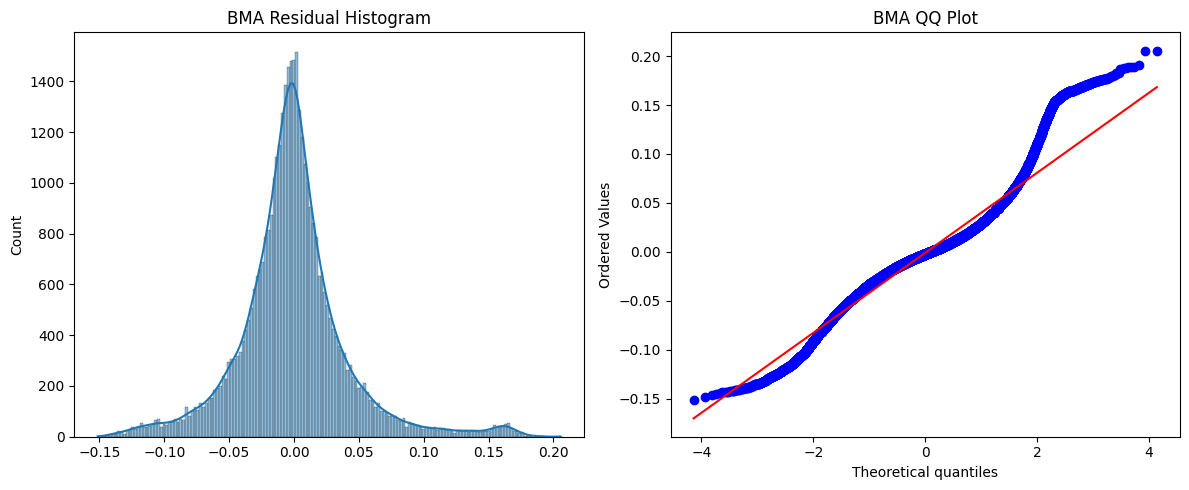

c:\Users\Justin\anaconda3\envs\crypto-env\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 39800.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk Test: W = 0.9356, p = 0.0000
Jarque-Bera Test: JB = 18736.8649, p = 0.0000
Ljung-Box Test (lag 10):
       lb_stat     lb_pvalue
10  239.187543  1.014739e-45
Durbin-Watson: 2.1315


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, jarque_bera, probplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
import numpy as np

# Residuals for BMA Ensemble
residuals = np.array(aligned_y_test) - np.array(ensemble_test_pred)

print("\n📉 Residual Diagnostics for: BMA Ensemble")

# 1. Histogram + QQ Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(residuals, kde=True, ax=ax[0])
ax[0].set_title("BMA Residual Histogram")

probplot(residuals, dist="norm", plot=ax[1])
ax[1].set_title("BMA QQ Plot")

plt.tight_layout()
plt.show()

# 2. Shapiro-Wilk Test
shapiro_stat, shapiro_p = shapiro(residuals)
print(f"Shapiro-Wilk Test: W = {shapiro_stat:.4f}, p = {shapiro_p:.4f}")

# 3. Jarque-Bera Test
jb_stat, jb_p = jarque_bera(residuals)
print(f"Jarque-Bera Test: JB = {jb_stat:.4f}, p = {jb_p:.4f}")

# 4. Ljung-Box Test (for autocorrelation up to lag 10)
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(f"Ljung-Box Test (lag 10):")
print(lb_test)

# 5. Durbin-Watson Test
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson: {dw_stat:.4f}")


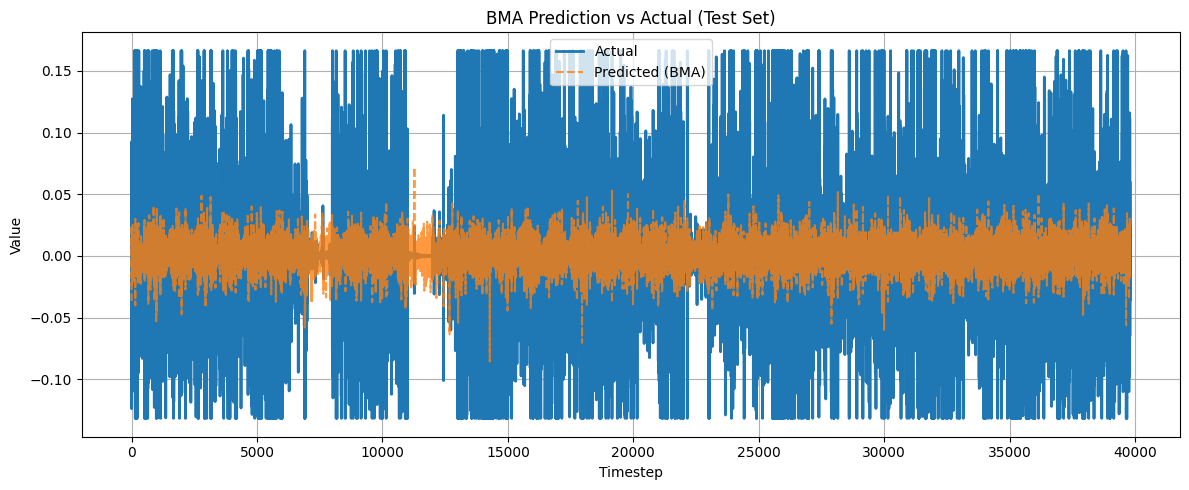

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(aligned_y_test, label="Actual", linewidth=2)
plt.plot(ensemble_test_pred, label="Predicted (BMA)", linestyle="--", alpha=0.8)
plt.title("BMA Prediction vs Actual (Test Set)")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
